# Imports

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from typing import Union
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf


plt.style.use('bmh')

nfl_colors = {
    "ARI": "#97233F",  # Arizona Cardinals
    "ATL": "#A71930",  # Atlanta Falcons
    "BAL": "#241773",  # Baltimore Ravens
    "BUF": "#00338D",  # Buffalo Bills
    "CAR": "#0085CA",  # Carolina Panthers
    "CHI": "#0B162A",  # Chicago Bears
    "CIN": "#FB4F14",  # Cincinnati Bengals
    "CLE": "#311D00",  # Cleveland Browns
    "DAL": "#041E42",  # Dallas Cowboys
    "DEN": "#FB4F14",  # Denver Broncos
    "DET": "#0076B6",  # Detroit Lions
    "GB":  "#203731",  # Green Bay Packers
    "HOU": "#03202F",  # Houston Texans
    "IND": "#002C5F",  # Indianapolis Colts
    "JAX": "#006778",  # Jacksonville Jaguars
    "KC":  "#E31837",  # Kansas City Chiefs
    "LAC": "#0080C6",  # Los Angeles Chargers
    "LAR": "#003594",  # Los Angeles Rams
    "LV":  "#000000",  # Las Vegas Raiders
    "MIA": "#008E97",  # Miami Dolphins
    "MIN": "#4F2683",  # Minnesota Vikings
    "NE":  "#002244",  # New England Patriots
    "NO":  "#D3BC8D",  # New Orleans Saints
    "NYG": "#0B2265",  # New York Giants
    "NYJ": "#125740",  # New York Jets
    "PHI": "#004C54",  # Philadelphia Eagles
    "PIT": "#FFB612",  # Pittsburgh Steelers
    "SEA": "#002244",  # Seattle Seahawks
    "SF":  "#AA0000",  # San Francisco 49ers
    "TB":  "#D50A0A",  # Tampa Bay Buccaneers
    "TEN": "#0C2340",  # Tennessee Titans
    "WAS": "#773141",
    "LA": "blue"# Washington Football Team
}

# Processing functions

In [3]:
def calculate_angle(point1, point2):
    dx = point1[0] - point2[0]
    dy = point1[1] - point2[1]
    
    # Calculate angle in radians using atan2
    angle_radians = np.arctan2(dy, dx)
    
    # Convert radians to degrees
    angle_degrees = np.degrees(angle_radians)
    
    
    
    return (angle_degrees -90) *-1


def _distance_from_point(x_distance: Union[float, np.ndarray], 
                        x_point: Union[float, np.ndarray], 
                        y_distance: Union[float, np.ndarray], 
                        y_point: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    """
    Calculate the Euclidean distance from a specific point or points to one or more other points.

    Parameters:
    x_distance (Union[float, np.ndarray]): X-coordinate(s) of the point(s) to calculate the distance to.
    x_point (Union[float, np.ndarray]): X-coordinate(s) of the reference point(s).
    y_distance (Union[float, np.ndarray]): Y-coordinate(s) of the point(s) to calculate the distance to.
    y_point (Union[float, np.ndarray]): Y-coordinate(s) of the reference point(s).

    Returns:
    Union[float, np.ndarray]: The Euclidean distance(s) between the pairs of points.
                               Returns a single float if the inputs are floats, or an array of floats if the inputs are arrays.
    """
    return np.sqrt((x_distance - x_point)**2 + (y_distance - y_point)**2)

def convert_height_to_inches(arr: pd.Series)->pd.Series:
    if arr.dtype == 'object':
        height_inches = arr.str[0].astype('int')*12 +arr.str[2].astype('int')
        return height_inches
    return arr

def flatten_and_rename(df,index_cols, value_cols):
    df.columns = index_cols + value_cols 
    return df
def calculate_yac(df:pd.DataFrame)->pd.Series:
    direction_right_bool = df['playDirection'] =='right'
    df['yac'] = df['end_play_event'] - df['pass_outcome_caught']
    df['yac'] = np.where(direction_right_bool,df['yac'],(-1*df['yac']))
    return df

def calculate_distance_down_field(df:pd.DataFrame)->pd.Series:
        direction_right_bool = df['playDirection'] =='right'
        df['yards_down_field'] = df['x'] - df['ball_carrier_x']
        df.loc[~direction_right_bool,'yards_down_field'] = -1* df['yards_down_field']
        return df
        
def calculate_distance_right(df:pd.DataFrame)-> pd.Series:
        direction_right_bool = df['playDirection'] =='right'
        df['yards_right'] = df['y'] - df['ball_carrier_y']
        df.loc[~direction_right_bool,'yards_right'] = -1* df['yards_right']
        return df
    

def calculate_distance_from_sideline(y: pd.Series)->pd.Series:
    return np.where(y > 53.3/2, 53.3-y , y)
    
def _angle_of_approach(theta_1, theta_2):
    # Calculate the difference in angles
    angle_diff = theta_1 - theta_2
    
    # Normalize the angle to be within -180 to 180 degrees
    angle_of_approach = (angle_diff + 180) % 360 - 180
    
    # The angle of approach should be the absolute value as it represents the magnitude
    # of the smallest angle needed to face the ball carrier
    angle_of_approach = abs(angle_of_approach)
    
    return angle_of_approach

def _angle_from_point(x_angle, x_point, y_angle, y_point):
    """
    Calculate the angle from a reference point (x_point, y_point) to a target point (x_angle, y_angle).
    The angle is calculated with 0 degrees being along the positive y-axis, and positive angles
    being clockwise from there.
    
    Parameters:
    x_angle (np.ndarray or pd.Series): x-coordinates of the target points
    x_point (np.ndarray or pd.Series): x-coordinates of the reference points
    y_angle (np.ndarray or pd.Series): y-coordinates of the target points
    y_point (np.ndarray or pd.Series): y-coordinates of the reference points
    
    Returns:
    np.ndarray or pd.Series: The angles from the reference points to the target points in degrees
    """

    x_diff = x_angle - x_point
    y_diff = y_angle - y_point
    angle_radians = np.arctan2( y_diff , x_diff)
    angle_degrees = (np.degrees(angle_radians) -90) * -1
    
    negative_angle_mask = angle_degrees < 0
    angle_degrees[negative_angle_mask] =  angle_degrees[negative_angle_mask] +360
    return angle_degrees

def _angle_of_approach(theta_1, theta_2) -> pd.DataFrame:
    # Calculate the difference in angles
    angle_diff = theta_1 - theta_2
    
    # Normalize the angle to the range [-180, 180)
    angle_of_approach = (angle_diff + 180) % 360 - 180
    
    # Since we want a positive angle representing the magnitude of the approach angle,
    # take the absolute value
    return np.abs(angle_of_approach)



def create_ball_carrier_position_cols(tracking_df, plays_df):
    """
    For all frames returns x, y,s,a,dis for ball carrier on play
    Preprocessing Step for calculate ball carrier diffs
    Creates 1 record per ball carrier
    """
    keep_cols = ['gameId','playId','ballCarrierDisplayName','frameId',
             'x', 'y', 's','a','dis','defensiveTeam','dir']
    rename_cols = ['x', 'y', 's','a','dis','o','a','dir']
    rename_prefix = 'ball_carrier_'
    final_join_cols = ['gameId','playId','frameId']
    return(tracking_df
           .merge(
                 plays_df, 
                 left_on= ['gameId','playId','nflId'], 
                 right_on = ['gameId','playId','ballCarrierId'], 
                 how = 'inner'
              )
           .loc[:, keep_cols]
           .rename({col :rename_prefix + col for col in rename_cols} , axis = 1)
          )

def calculate_ball_carrier_diffs(ball_carrier_pos_df: pd.DataFrame)-> pd.DataFrame:
    return (ball_carrier_pos_df
           .assign(distance_from_ball_carrier = lambda df: _distance_from_point(df['x'],df['ball_carrier_x'],df['y'],df['ball_carrier_y']),
                   
                   angle_from_ball_carrier = lambda df: _angle_from_point(df['ball_carrier_x'],df['x'],df['ball_carrier_y'],df['y']), 
                   angle_of_approach = lambda df: _angle_of_approach(df['angle_from_ball_carrier'] , df['dir']),
                   cos_angle_of_approach = lambda df: cos_in_degrees(df['angle_of_approach']),
                   ball_carrier_distance_from_sideline = lambda df: calculate_distance_from_sideline(df['ball_carrier_y']),
                   player_distance_from_sideline = lambda df: calculate_distance_from_sideline(df['y'])
                  )
            
           .pipe(lambda df: calculate_distance_down_field(df))
           .pipe(lambda df: calculate_distance_right(df))
        )
    
def create_event_frame_intermediate_join(tracking_df, event = "pass_outcome_caught"):
    return tracking_df.loc[tracking_df['event']==event,['gameId','playId','frameId']].drop_duplicates().reset_index(drop = True)

def players_within_x(df, cutoff_distance = 3):
    return np.sum((df['distance_from_ball_carrier'] <= cutoff_distance))

def calculate_players_within_radius(distance_from_ball_carrier, cutoff_distance):
    return np.sum((distance_from_ball_carrier <= cutoff_distance))
    
def calculate_players_downfield_within_radius(df, cutoff_downfield, cutoff_radius):
    downfield_mask = df['yards_down_field'] <= cutoff_downfield
    radius_mask = df ['distance_from_ball_carrier'] <= cutoff_radius
    total_mask = (downfield_mask) & (radius_mask)
    return np.sum(total_mask)
    
def calculate_players_upfield_within_radius(df, cutoff_upfield, cutoff_radius):
    downfield_mask = df['yards_down_field'].between(cutoff_upfield,-0.0001)
    radius_mask = df ['distance_from_ball_carrier'] <= cutoff_radius
    total_mask = (downfield_mask) & (radius_mask)
    return np.sum(total_mask)
     

def towards_sideline_vector(value,angle):
    angle_radians = np.radians((angle))
    return np.abs(value*np.cos(angle_radians))

def towards_endzone_vector(value,angle):
    angle_radians = np.radians(angle)
    return np.abs(value*np.sin(angle_radians))

def map_angle_to_category(angle):
    if 315 <= angle or angle <= 45:
        return 'sideline'
    elif 45 < angle <= 135:
        return 'endzone'
    elif 135 < angle <= 225 :
        return 'sideline'
    # You can add more conditions for other ranges
    else:
        return 'endzone'  # Default category for angles that don't fit the above criteria

def calculate_distance_from_sideline(y: pd.Series)->pd.Series:
    return np.where(y > 53.3/2, 53.3-y , y)
    
    
def cos_in_degrees(angle_degrees):
    return np.cos(np.radians(angle_degrees))

def create_behind_los_flag(yac_df:pd.DataFrame):
    direction_right_mask = yac_df['playDirection'] == 'right'
    abs_greater_than_catch_mask = yac_df['absoluteYardlineNumber'] > yac_df['pass_outcome_caught']
    
    left_los_mask = direction_right_mask & abs_greater_than_catch_mask
    right_los_mask = ~direction_right_mask & ~abs_greater_than_catch_mask
    
    yac_df['behind_los_flag'] = 0
    yac_df.loc[left_los_mask,'behind_los_flag'] = 1
    yac_df.loc[right_los_mask,'behind_los_flag'] = 1
    
    return yac_df[['gameId','playId','behind_los_flag']]



def plot_actual_vs_predicted(y_pred, y_test, title =''):
    if not title:
        title = 'Actual vs. Predicted  Values with R-squared'
    r_squared= r2_score( y_test, y_pred)
    
    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=y_test)

    # Add the y=x line
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')

    # Annotate the plot with the R-squared value
    plt.text(x=min(y_pred), y=max(y_test), s=f'R-squared = {r_squared:.2f}')

    # Label the axes and show the plot
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()
    
    
def subtract_series_set_negative_to_zero(series1, series2):
    # Subtract series2 from series1
    result = series1 - series2
    # Set negative results to zero
    result[result < 0] = 0
    return result

def calculate_snap_to_catch_diff(tracking_df):
    df_snap = tracking_df[tracking_df['event'] == 'ball_snap'][['gameId','playId','time']]
    df_catch = tracking_df[tracking_df['event'] == 'pass_outcome_caught'][['gameId','playId','time']]
                                                                      
    # Merge the DataFrames on gameId and playId
    merged_df = pd.merge(df_snap, df_catch, on=['gameId', 'playId'], suffixes=('_snap', '_catch'))
    
    # Convert the time columns to datetime
    merged_df['time_snap'] = pd.to_datetime(merged_df['time_snap'], format='%Y-%m-%d %H:%M:%S')
    merged_df['time_catch'] = pd.to_datetime(merged_df['time_catch'], format='%Y-%m-%d %H:%M:%S')
    
    # Calculate the time difference in seconds
    merged_df['snap_to_catch_time'] = (merged_df['time_catch'] - merged_df['time_snap']).dt.total_seconds()
    
    # Return the DataFrame with the difference
    return merged_df[['gameId', 'playId', 'snap_to_catch_time']].drop_duplicates().reset_index(drop=True)  


def rank_distance_from_ball_carrier(df: pd.DataFrame)->pd.Series:
    return (df
            .groupby(['gameId','playId','offense_or_defense'],as_index = False)['distance_from_ball_carrier']
            .rank(method = 'min')
           )
    

# Read In Data

In [4]:
tackle_df = pd.read_csv('nfl-big-data-bowl-2024/tackles.csv')
plays_df = pd.read_csv('nfl-big-data-bowl-2024/plays.csv')
players_df = pd.read_csv('nfl-big-data-bowl-2024/players.csv')
tracking_df = pd.concat(
    
                     [
                     pd.read_csv('nfl-big-data-bowl-2024/tracking_week_8.csv'),
                     pd.read_csv('nfl-big-data-bowl-2024/tracking_week_7.csv'),
                     pd.read_csv('nfl-big-data-bowl-2024/tracking_week_6.csv'),
                     pd.read_csv('nfl-big-data-bowl-2024/tracking_week_5.csv'),
                     pd.read_csv('nfl-big-data-bowl-2024/tracking_week_4.csv'),
                     pd.read_csv('nfl-big-data-bowl-2024/tracking_week_3.csv'),
                     pd.read_csv('nfl-big-data-bowl-2024/tracking_week_2.csv'),
                     pd.read_csv('nfl-big-data-bowl-2024/tracking_week_1.csv')
                    ]
)

# Prepare Players Data

In [5]:
players_df['height'] = convert_height_to_inches(players_df['height'])

# Prepare Plays Data

In [6]:
plays_df = (plays_df
            .query('passResult =="C"') # Filter to plays with a catch
            .assign(
                minute_of_quarter=lambda df: df['gameClock'].str.split(':', expand=True)[0].astype(int),
                abs_score_diff=lambda df: np.abs(df['preSnapHomeScore'] - df['preSnapVisitorScore'])
            )
            .merge(tracking_df[['playId','gameId','playDirection']].drop_duplicates(), on = ['playId','gameId'], how = 'inner')
           )


end_of_half_mask = ~((plays_df['quarter'].isin([2,4])) & (plays_df['minute_of_quarter'] <= 2)) # When Against the clock teams don't go for extra yards
end_4th_blowout_mask =  ~((plays_df['quarter'] == 4) & (plays_df['minute_of_quarter'] <= 5) & (plays_df['abs_score_diff'] < 10)) # Eliminate Times of Game when Shell Defense
redzone_mask_left = (plays_df['playDirection'] == 'left') & (plays_df['absoluteYardlineNumber'] >= 35) 
redzone_mask_right = (plays_df['playDirection'] == 'right') & (plays_df['absoluteYardlineNumber'] <= 85)

redzone_mask = redzone_mask_left | redzone_mask_right

total_mask = end_of_half_mask & end_4th_blowout_mask & redzone_mask


# Remove Plays with Missed Tackles
no_missed_tackle_id_df = tackle_df.query('pff_missedTackle == 1')[['gameId','playId']].drop_duplicates().reset_index(drop=True)





plays_df = (plays_df.loc[total_mask,]
          .merge(no_missed_tackle_id_df, on = ['gameId','playId'], how = 'left', indicator = True )
          .query('_merge == "left_only"')
          .drop('minute_of_quarter', axis = 1)
          .assign(yards_from_td = lambda df: np.where(df['playDirection'] =='right', 110 - df['absoluteYardlineNumber'],df['absoluteYardlineNumber']-10))
          .merge(players_df[['nflId','height','weight']] ,left_on = 'ballCarrierId', right_on = 'nflId', how = 'inner')
          .rename({'height':'ball_carrier_height', 'weight':'ball_carrier_weight'},axis = 1)
          .drop('nflId',axis =1)
           )
np.sum(redzone_mask)

4531

# Create Ball Carrier Diffs

In [7]:
tracking_cols = ['gameId','playId','nflId','frameId','x','y','s','a','dis','playDirection','displayName','club','dir','o']
player_cols = ['height','weight','position','nflId']
ball_carrier_diffs =    (create_ball_carrier_position_cols(tracking_df, plays_df) # Creates One record per ball carrier on play with position cols
                        .merge(tracking_df[tracking_cols], on = ['gameId','playId','frameId'] , how = 'inner') # Joins all tracking data to setup distance calcs
                        .pipe(lambda df: calculate_ball_carrier_diffs(df)) # Calculates distances from ball carrier
                        .merge(players_df[player_cols], on = 'nflId', how = 'inner') # Adds additional player info on the nflId
                        .assign(offense_or_defense = lambda df: np.where(df['club'] == df['defensiveTeam'],'D','O') ) # Assigns player to offense or defense on the play
)



# Create YAC DF

In [8]:

track_df_keep_cols = ['gameId','playId','nflId','displayName','frameId','event','x','y','club']
play_df_keep_cols = ['down',
                     'yardsToGo',
                     'abs_score_diff',
                     'playDescription',
                     'playDirection',
                     'quarter',
                     'gameClock',
                     'passLength',
                     'yardlineNumber',
                     'absoluteYardlineNumber',
                     'defendersInTheBox']
index_cols = ['gameId',
              'playId',
              'nflId',
              'displayName',
              'playDirection',
              'yardlineNumber',
              'down',
              'yardsToGo',
              'playDescription',
              'quarter',
              'abs_score_diff',
              'gameClock',
              'passLength',
              'absoluteYardlineNumber',
              'defendersInTheBox'
             ]



end_play_event_map = {
    "pass_outcome_caught":"pass_outcome_caught",
    "tackle":"end_play_event",
    "out_of_bounds":"end_play_event",
    "fumble":"end_play_event",
#     "touchdown" :"end_play_event" 
}

end_of_event_cols = ['fumble','out_of_bounds','pass_outcome_caught','tackle'] 
calc_cols = ['pass_outcome_caught','end_of_event']


yac_df = (tracking_df.loc[tracking_df['displayName'] == 'football', track_df_keep_cols]
    .merge(plays_df, left_on= ['gameId','playId'] , right_on = ['gameId','playId'], how = 'inner')
    .query('event == "pass_outcome_caught" | event == "tackle" | event =="out_of_bounds" | event == "fumble"')
    .assign(end_play_event = lambda df: df['event'].map(end_play_event_map))
    .sort_values(['gameId','playId','frameId'])
    .pivot(index = index_cols,columns =['event'], values=['x'] )
    .reset_index()
    .pipe(lambda df: flatten_and_rename(df,index_cols,end_of_event_cols))
    .query("pass_outcome_caught > 10 & pass_outcome_caught < 110") # Filter for Touchdowns in the end zone
    .assign(end_play_event = lambda df: df['tackle'].combine_first(df['out_of_bounds'].combine_first(df['fumble'])))
    .pipe(lambda df: calculate_yac(df))
    # .assign(yac = lambda df: np.where(df['yac'] <0 ,0,df['yac']))
    .query("yac > -3")
    .query("yac < 40")
    .assign(yac = lambda df:  df['yac'] + 3.1)
)
          
          

# Create Behind LOS Flag DF

<Axes: xlabel='yac', ylabel='Count'>

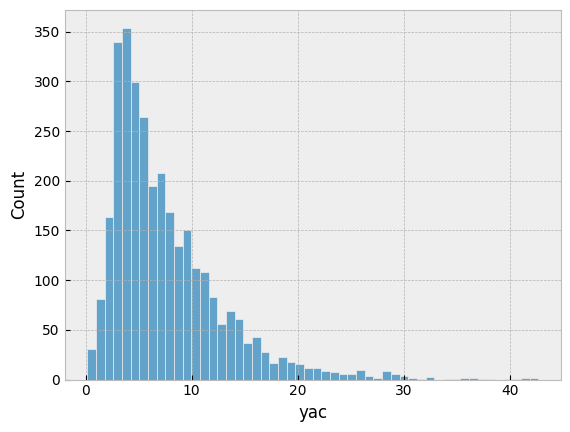

In [9]:
sns.histplot(yac_df['yac'])

In [10]:
behind_los_flag_df = create_behind_los_flag(yac_df)  

# Create Feature Setup DF

In [11]:
yac_df_cols = ['gameId',
               'playId',
               'yac',
               'down',
               'yardsToGo',
               'quarter',
               'gameClock',
               'passLength',
               'yardlineNumber',
               'absoluteYardlineNumber',
               'defendersInTheBox',
               'abs_score_diff',
              ]
feature_setup_df = (yac_df[yac_df_cols]
.merge(create_event_frame_intermediate_join(tracking_df) , on = ['gameId','playId'])
.merge(ball_carrier_diffs, on = ['gameId','playId','frameId'], how = 'inner')
.query("ballCarrierDisplayName != displayName" )
.assign(ball_carrier_speed_toward_sideline = lambda df: towards_sideline_vector(df['ball_carrier_s'],df['ball_carrier_dir']),
        ball_carrier_speed_toward_endzone = lambda df: towards_endzone_vector(df['ball_carrier_s'],df['ball_carrier_dir']),
        player_carrier_speed_toward_endzone = lambda df: towards_endzone_vector(df['s'],df['dir']),
        player_carrier_speed_toward_sideline = lambda df: towards_sideline_vector(df['s'],df['dir']),
        ranked_closest_player = lambda df: rank_distance_from_ball_carrier(df),
        speed_times_cos_angle_approach = lambda df: df['cos_angle_of_approach'] * df['s'],
        distance_times_cos_angle_approach = lambda df: df['cos_angle_of_approach'] *df['distance_from_ball_carrier'] ,
        # height_diff = lambda df: df['ball_carrier_height'] - df['height'],
        # weight_diff = lambda df: df['ball_carrier_weight'] - df['weight']
       )
)



# Feature Setup Display
feature_setup_df_display = (yac_df[yac_df_cols]
.merge(create_event_frame_intermediate_join(tracking_df) , on = ['gameId','playId'])
.merge(ball_carrier_diffs, on = ['gameId','playId','frameId'], how = 'inner')
.assign(ball_carrier_speed_toward_sideline = lambda df: towards_sideline_vector(df['ball_carrier_s'],df['ball_carrier_dir']),
        ball_carrier_speed_toward_endzone = lambda df: towards_endzone_vector(df['ball_carrier_s'],df['ball_carrier_dir']),
        player_carrier_speed_toward_endzone = lambda df: towards_endzone_vector(df['s'],df['dir']),
        player_carrier_speed_toward_sideline = lambda df: towards_sideline_vector(df['s'],df['dir']),
        ranked_closest_player = lambda df: rank_distance_from_ball_carrier(df),
        speed_times_cos_angle_approach = lambda df: df['cos_angle_of_approach'] * df['s'],
        distance_times_cos_angle_approach = lambda df: df['cos_angle_of_approach'] *df['distance_from_ball_carrier'] ,
        # height_diff = lambda df: df['ball_carrier_height'] - df['height'],
        # weight_diff = lambda df: df['ball_carrier_weight'] - df['weight']
       )
)


# Create Ball Carrier Metrics DF

In [12]:
ball_carrier_cols = ['gameId','playId'] + list(feature_setup_df.filter(like = 'ball_carrier_', axis = 1).columns)

ball_carrier_metrics_df = feature_setup_df[ball_carrier_cols].drop_duplicates().reset_index(drop=True)

# Create Closest Players O and D DF

In [13]:
# # Build Closest Defender df
# d_mask = feature_setup_df['offense_or_defense'] == 'D'
# closest_defender_df = (feature_setup_df[d_mask]
# .groupby(['gameId','playId'],as_index = False)
# .agg({'distance_from_ball_carrier':min})
# .merge(feature_setup_df , on = ['gameId','playId','distance_from_ball_carrier'],how ='inner')
# )


# # Build closest Offensive df

# o_mask = feature_setup_df['offense_or_defense'] == 'O'
# closest_offensive_df = (feature_setup_df[o_mask]
# .groupby(['gameId','playId'],as_index = False)
# .agg({'distance_from_ball_carrier':min})
# .merge(feature_setup_df , on = ['gameId','playId','distance_from_ball_carrier'],how ='inner')
# )

# closest_defender_df.columns = [f"{col}_closest_defender" for col in closest_defender_df.columns] 
# closest_offensive_df.columns = [f"{col}_closest_offense" for col in closest_offensive_df.columns]

# # closest_offensive_df.columns

In [14]:
feature_setup_df.columns

Index(['gameId', 'playId', 'yac', 'down', 'yardsToGo', 'quarter', 'gameClock',
       'passLength', 'yardlineNumber', 'absoluteYardlineNumber',
       'defendersInTheBox', 'abs_score_diff', 'frameId',
       'ballCarrierDisplayName', 'ball_carrier_x', 'ball_carrier_y',
       'ball_carrier_s', 'ball_carrier_a', 'ball_carrier_dis', 'defensiveTeam',
       'ball_carrier_dir', 'nflId', 'x', 'y', 's', 'a', 'dis', 'playDirection',
       'displayName', 'club', 'dir', 'o', 'distance_from_ball_carrier',
       'angle_from_ball_carrier', 'angle_of_approach', 'cos_angle_of_approach',
       'ball_carrier_distance_from_sideline', 'player_distance_from_sideline',
       'yards_down_field', 'yards_right', 'height', 'weight', 'position',
       'offense_or_defense', 'ball_carrier_speed_toward_sideline',
       'ball_carrier_speed_toward_endzone',
       'player_carrier_speed_toward_endzone',
       'player_carrier_speed_toward_sideline', 'ranked_closest_player',
       'speed_times_cos_angle_approa

# N Closest Players

In [15]:
# Create a new column combining rank with offense/defense
feature_setup_df['pivot_column'] = "closest_player" + "_" + feature_setup_df['ranked_closest_player'].astype(int).astype(str) + '_' + feature_setup_df['offense_or_defense']

# Use these on join for model setup
n_closest_index_cols = [
              'gameId', 
              'playId',
        ]


value_cols = ['yards_down_field', 
              'cos_angle_of_approach',
              'speed_times_cos_angle_approach',
              'distance_times_cos_angle_approach',
              'distance_from_ball_carrier',
              'yards_right'
             ]

n_closest_player_metrics = (feature_setup_df
    .query('ranked_closest_player < 7')
    .pivot_table(
                index=n_closest_index_cols,
                columns='pivot_column',
                values=value_cols
    ).reset_index()
)

n_closest_player_metrics.columns = list(n_closest_index_cols) +  ['_'.join(col).strip() for col in n_closest_player_metrics.iloc[:,len(n_closest_index_cols):]]

n_closest_player_metrics

,gameId,playId,cos_angle_of_approach_closest_player_1_D,cos_angle_of_approach_closest_player_1_O,cos_angle_of_approach_closest_player_2_D,cos_angle_of_approach_closest_player_2_O,cos_angle_of_approach_closest_player_3_D,cos_angle_of_approach_closest_player_3_O,cos_angle_of_approach_closest_player_4_D,cos_angle_of_approach_closest_player_4_O,...,yards_right_closest_player_2_D,yards_right_closest_player_2_O,yards_right_closest_player_3_D,yards_right_closest_player_3_O,yards_right_closest_player_4_D,yards_right_closest_player_4_O,yards_right_closest_player_5_D,yards_right_closest_player_5_O,yards_right_closest_player_6_D,yards_right_closest_player_6_O
0,2022090800,56,0.814612,-0.967214,0.722822,0.763387,0.958609,-0.730889,0.699949,-0.854480,...,2.23,6.28,6.85,4.25,5.95,5.60,-0.50,8.89,2.45,3.15
1,2022090800,122,0.974375,0.939816,0.773777,0.563661,0.690700,-0.216816,0.986698,0.997603,...,3.71,5.97,2.48,7.03,6.87,7.78,8.87,7.19,5.22,4.89
2,2022090800,167,0.810325,0.153423,0.899492,-0.999087,0.695559,-0.450665,-0.803074,0.892559,...,7.45,3.34,-1.31,0.79,3.64,12.13,0.26,3.73,10.64,3.10
3,2022090800,212,0.838452,0.299848,0.379905,-0.429267,-0.540330,0.816117,0.963445,0.989583,...,1.88,6.98,6.37,9.76,12.32,11.75,14.37,14.25,16.53,16.52
4,2022090800,364,0.796360,0.993687,0.979249,0.696104,0.988429,0.650854,0.902185,0.904531,...,4.33,22.23,8.67,15.34,15.64,24.91,20.25,22.03,18.00,27.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3162,2022103100,2789,0.951549,0.968501,0.461500,0.947602,-0.465653,0.496803,0.439011,0.863281,...,9.34,9.10,9.04,9.80,13.35,9.25,3.88,8.40,-10.51,12.55
3163,2022103100,3087,0.984392,-0.070183,0.826242,0.216256,0.931808,0.851021,-0.296134,0.387248,...,2.76,6.28,8.21,-8.92,6.41,-10.61,-8.75,-15.40,8.62,-14.07
3164,2022103100,3189,0.901102,0.985899,0.904495,0.999973,0.582919,0.997791,0.989515,0.999889,...,-7.34,-9.71,-7.73,-9.56,-9.33,-10.76,-8.14,-10.61,-9.42,-10.18
3165,2022103100,3275,0.993709,0.934799,0.918677,-0.931747,-0.947197,0.973616,0.948375,0.986361,...,9.95,-1.00,-0.39,21.09,15.50,23.56,4.94,24.51,23.48,26.33


# Visualize Play and Check Feature Setup Caculations

In [16]:
feature_setup_df[['playId','gameId','yac','playDirection']].sort_values('yac', ascending = False).drop_duplicates().iloc[40:60]

,playId,gameId,yac,playDirection
16340,1390,2022091811,27.270002,right
47733,664,2022101604,26.910005,right
50549,181,2022101609,26.770002,left
26190,989,2022092512,26.729997,right
32731,1107,2022100208,26.720003,right
24983,1497,2022092510,26.280000,right
47945,1509,2022101604,26.269998,right
34950,2283,2022100213,26.259996,right
68013,2955,2022103010,26.170000,right
44042,1401,2022100913,26.080003,right


In [17]:
play_id =2179
game_id = 2022092600
feature_setup_df[['ballCarrierDisplayName',
                  'displayName',
                  'club',
                  'ball_carrier_speed_toward_endzone',
                  'ball_carrier_speed_toward_sideline',
                  'ball_carrier_s',
                  'absoluteYardlineNumber',        
                  'distance_from_ball_carrier',
                  'playDirection',
                  'ball_carrier_x', 
                  'ball_carrier_y',
                  'x',
                  'y',
                  'angle_from_ball_carrier',
                  'angle_of_approach',
                  'cos_angle_of_approach',
                  'dir',
                  'yards_down_field',
                  'yards_right',
                  'playDirection',
                  'passLength',
                  
         'ball_carrier_speed_toward_sideline',
         'ball_carrier_speed_toward_endzone',
         'player_carrier_speed_toward_endzone',
         'player_carrier_speed_toward_sideline',
         'dis',
         's',
         'o',
         'offense_or_defense',
          'yac']].loc[(feature_setup_df['playId'] == play_id) & (feature_setup_df['gameId'] == game_id),].sort_values(['offense_or_defense','distance_from_ball_carrier']).head(12)

,ballCarrierDisplayName,displayName,club,ball_carrier_speed_toward_endzone,ball_carrier_speed_toward_sideline,ball_carrier_s,absoluteYardlineNumber,distance_from_ball_carrier,playDirection,ball_carrier_x,...,passLength,ball_carrier_speed_toward_sideline,ball_carrier_speed_toward_endzone,player_carrier_speed_toward_endzone,player_carrier_speed_toward_sideline,dis,s,o,offense_or_defense,yac
27478,Saquon Barkley,Demarcus Lawrence,DAL,1.591317,4.80326,5.06,72,5.038770,right,68.8,...,-2.0,4.80326,1.591317,1.794833,2.366321,0.29,2.97,51.76,D,19.890001
27480,Saquon Barkley,Leighton Vander Esch,DAL,1.591317,4.80326,5.06,72,7.004070,right,68.8,...,-2.0,4.80326,1.591317,1.141430,5.696774,0.58,5.81,293.80,D,19.890001
27485,Saquon Barkley,Osa Odighizuwa,DAL,1.591317,4.80326,5.06,72,7.040810,right,68.8,...,-2.0,4.80326,1.591317,0.723731,1.302426,0.14,1.49,31.02,D,19.890001
27493,Saquon Barkley,Quinton Bohanna,DAL,1.591317,4.80326,5.06,72,8.069430,right,68.8,...,-2.0,4.80326,1.591317,0.083859,0.442117,0.05,0.45,24.92,D,19.890001
27484,Saquon Barkley,Micah Parsons,DAL,1.591317,4.80326,5.06,72,8.448207,right,68.8,...,-2.0,4.80326,1.591317,1.328933,2.700748,0.30,3.01,163.20,D,19.890001
27482,Saquon Barkley,Donovan Wilson,DAL,1.591317,4.80326,5.06,72,10.509205,right,68.8,...,-2.0,4.80326,1.591317,0.856983,5.250522,0.52,5.32,198.36,D,19.890001
27481,Saquon Barkley,Dorance Armstrong,DAL,1.591317,4.80326,5.06,72,10.679799,right,68.8,...,-2.0,4.80326,1.591317,2.293863,4.352539,0.51,4.92,171.05,D,19.890001
27492,Saquon Barkley,Malik Hooker,DAL,1.591317,4.80326,5.06,72,19.613773,right,68.8,...,-2.0,4.80326,1.591317,1.450905,1.347321,0.20,1.98,297.95,D,19.890001
27479,Saquon Barkley,Anthony Brown,DAL,1.591317,4.80326,5.06,72,19.691724,right,68.8,...,-2.0,4.80326,1.591317,4.326845,2.299656,0.50,4.90,2.34,D,19.890001
27483,Saquon Barkley,Trevon Diggs,DAL,1.591317,4.80326,5.06,72,31.070893,right,68.8,...,-2.0,4.80326,1.591317,1.705188,0.636187,0.18,1.82,210.03,D,19.890001


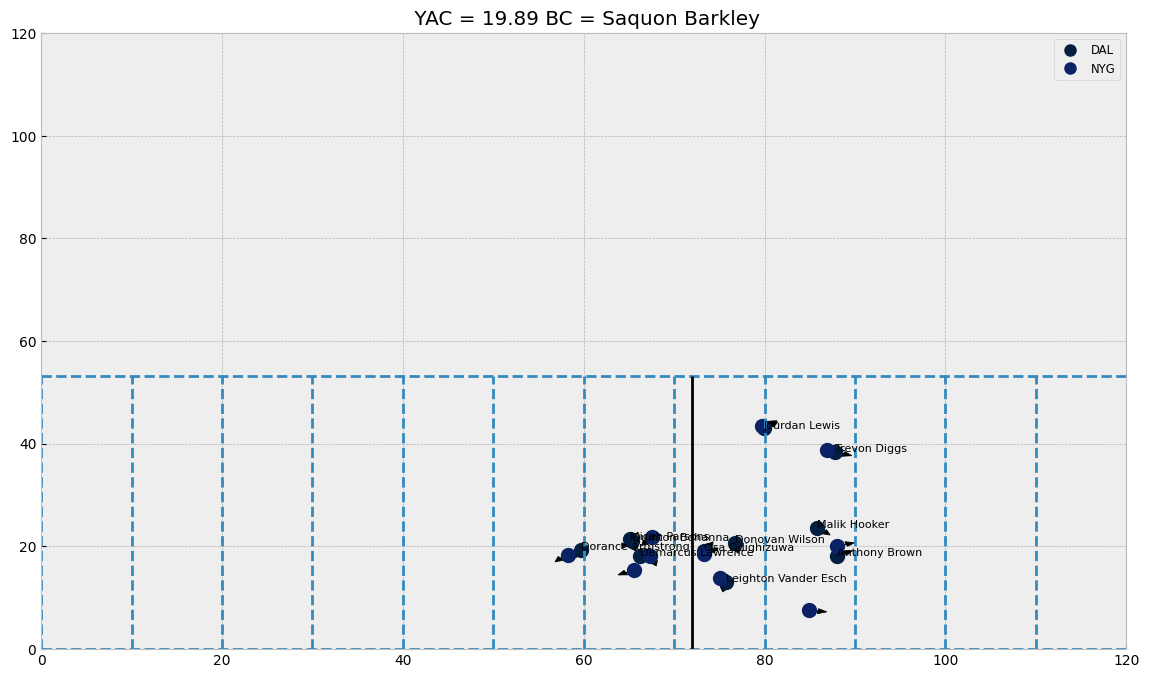

In [18]:
# Assuming nfl_colors is defined previously and feature_setup_df is your dataframe
colors = nfl_colors

# Set up the plot again with the requested adjustments
fig, ax = plt.subplots(figsize=(14, 8))  # Adjust the size to your preference

play_mask = (feature_setup_df['playId'] == play_id) & (feature_setup_df['gameId'] == game_id)

# Find the unique clubs involved in this specific play
unique_clubs = feature_setup_df.loc[play_mask, 'club'].unique()

# Initialize a dictionary to hold the legend handles to ensure unique labels
legend_handles = {}

# Plot player positions with colors based on 'club'
for _, row in feature_setup_df.loc[play_mask].iterrows():
    bc_name = row['ballCarrierDisplayName']
    o_d = row['offense_or_defense']
    club_color = colors[row['club']]
    if row['club'] not in legend_handles:
        # Only add to legend if not already present
        legend_handles[row['club']] = plt.Line2D([0], [0], marker='o', color=club_color, markersize=8, linestyle='')

    ax.plot(row['x'], row['y'], 'o', markersize=10, color=club_color, label=row['club'])  # Larger dots
    # Annotate player name at a quarter of the default font size
    if o_d =='D' or row['displayName'] == bc_name:
        ax.text(row['x'], row['y'], row['displayName'], fontsize=plt.rcParams['font.size'] * 0.8)

    # Calculate the arrow direction based on the 'dir' column
    radians = np.radians((row['dir'] -90) * -1)
    dx = np.cos(radians)  # Change in x
    dy = np.sin(radians)  # Change in y

    # Draw the arrow from the player position in the direction they're facing
    ax.arrow(row['x'], row['y'], dx, dy, head_width=1, head_length=1, fc='k', ec='k')
    
    yac_title = np.round(row['yac'],2)
    ball_carrier = row['ballCarrierDisplayName']
    line_of_scrimmage = row['absoluteYardlineNumber']

# Set the limits of the plot
ax.set_xlim([0, 120])
ax.set_ylim([0, 120])
ax.hlines(y = [0,53.3],xmin = 0, xmax =120, linestyle = '--')
ax.vlines(x = line_of_scrimmage,ymin = 0, ymax =53.3, color = 'black')
ax.vlines(x = range(0,120,10),ymin = 0, ymax =53.3, linestyle = '--')
# Set title to include the two teams
if len(unique_clubs) == 2:
    title_teams = f"{unique_clubs[0]} vs {unique_clubs[1]}"
else:
    title_teams = "Multiple Teams"
ax.set_title(f' YAC = {yac_title} BC = {ball_carrier}')

# Create and add the legend for the clubs
handles, labels = [], []
for club in unique_clubs:
    handles.append(legend_handles[club])
    labels.append(club)
ax.legend(handles, labels, loc='upper right', fontsize='small')

# Show the plot
plt.show()

# Apply and Aggregate for Closest Player Features

In [19]:
group_by_list = ['gameId',
                 'playId',
                 'yardsToGo', 
                 'yac', 
                 'ballCarrierDisplayName', 
                 'offense_or_defense',
                 'down',
                 'quarter',
                 'gameClock',
                 'abs_score_diff',
                 'passLength',
                 'absoluteYardlineNumber',
                 'defendersInTheBox'
                ]


# apply_result_df = (feature_setup_df
#                 .groupby(group_by_list, as_index=False)
#                 .apply(lambda df: pd.Series({
#                     'players_downfield_within_1': calculate_players_downfield_within_radius(df, 1, 1),
#                     'players_downfield_within_3': calculate_players_downfield_within_radius(df, 3, 3),
#                     'players_downfield_within_5': calculate_players_downfield_within_radius(df, 5, 5),
#                     'players_downfield_within_7': calculate_players_downfield_within_radius(df, 7, 7),
#                     'players_downfield_within_10': calculate_players_downfield_within_radius(df, 10, 10),
#                     'players_downfield_within_15': calculate_players_downfield_within_radius(df, 15, 15),
#                     'players_upfield_within_1': calculate_players_upfield_within_radius(df, -1, 1),
#                     'players_upfield_within_3': calculate_players_upfield_within_radius(df, -3, 3),
#                     'players_upfield_within_5': calculate_players_upfield_within_radius(df, -5, 5),
#                     'players_upfield_within_7': calculate_players_upfield_within_radius(df, -7, 7),
#                     'players_upfield_within_10': calculate_players_upfield_within_radius(df, -10, 10),
#                     'players_upfield_within_15': calculate_players_upfield_within_radius(df, -15, 15),
#                 })))


apply_index_cols = ['gameId',
                 'playId',
                 'yardsToGo', 
                 'yac', 
                 'ballCarrierDisplayName', 
#                  'offense_or_defense',
                 'down',
                 'quarter',
                 'gameClock',
                 'abs_score_diff',
                 'passLength',
                 'absoluteYardlineNumber',
                 'defendersInTheBox'
                ]

apply_results_df = (feature_setup_df
                .groupby(group_by_list, as_index=False)
                .apply(lambda df: pd.Series({
                    'players_downfield_within_1': calculate_players_downfield_within_radius(df, 1, 1),
                    'players_downfield_within_2': calculate_players_downfield_within_radius(df, 2, 2),
                    'players_downfield_within_3': calculate_players_downfield_within_radius(df, 3, 3),
                    'players_downfield_within_5': calculate_players_downfield_within_radius(df, 5, 5),
                    'players_downfield_within_10': calculate_players_downfield_within_radius(df, 10, 10),
                    'players_upfield_within_1': calculate_players_upfield_within_radius(df, -1, 1),
                    'players_upfield_within_3': calculate_players_upfield_within_radius(df, -3, 3),
                    'players_upfield_within_5': calculate_players_upfield_within_radius(df, -5, 5),
                    'players_upfield_within_10': calculate_players_upfield_within_radius(df, -10, 10),
                    'players_behind_ball_carrier': calculate_players_upfield_within_radius(df, -120, 120)
                })))




apply_value_cols = ['players_downfield_within_1'
                    ,'players_downfield_within_2'
                    ,'players_downfield_within_3'
                    ,'players_downfield_within_5'
                    ,'players_downfield_within_10'
                    , 'players_upfield_within_1'
                    ,'players_upfield_within_3'
                    ,'players_upfield_within_5'
                    ,'players_upfield_within_10'
                    ,'players_behind_ball_carrier'
                   ]

apply_rename_cols = ['players_downfield_within_1_D'
                     ,'players_downfield_within_1_O'
                     ,'players_downfield_within_2_D'
                     ,'players_downfield_within_2_O'
                     ,'players_downfield_within_3_D'
                     ,'players_downfield_within_3_O'
                     ,'players_downfield_within_5_D'
                     ,'players_downfield_within_5_O'
                     ,'players_downfield_within_10_D'
                     ,'players_downfield_within_10_O'
                     ,'players_upfield_within_1_D'
                     ,'players_upfield_within_1_O'
                     ,'players_upfield_within_3_D'
                     ,'players_upfield_within_3_O'
                     ,'players_upfield_within_5_D'
                     ,'players_upfield_within_5_O'
                     ,'players_upfield_within_10_D'
                     ,'players_upfield_within_10_O'
                     ,'players_behind_ball_carrier_D'
                     ,'players_behind_ball_carrier_O'
                   ]

players_up_down_field_df = (apply_results_df.pivot(index = apply_index_cols
                      ,columns = ['offense_or_defense']
                      ,values = apply_value_cols)
                      .reset_index()
                      .pipe(lambda df: flatten_and_rename(df,apply_index_cols,apply_rename_cols))
)






agg_result = (feature_setup_df
              .groupby(['gameId', 'playId', 'yardsToGo', 'yac', 'ballCarrierDisplayName','offense_or_defense'], as_index=False)
              .agg({'distance_from_ball_carrier': [('within_radius_1', lambda x: calculate_players_within_radius(x, cutoff_distance=1)),
                                                   ('within_radius_2', lambda x: calculate_players_within_radius(x, cutoff_distance=2)),
                                                   ('within_radius_3', lambda x: calculate_players_within_radius(x, cutoff_distance=3)),
                                                   ('within_radius_5', lambda x: calculate_players_within_radius(x, cutoff_distance=5)),
                                                  ('within_radius_10', lambda x: calculate_players_within_radius(x, cutoff_distance=10))]
                   })

             )
                    
    
agg_result.columns =  ['_'.join(col).rstrip('_') for col in agg_result.columns.to_flat_index()]







value_cols = ['distance_from_ball_carrier_within_radius_1',
              'distance_from_ball_carrier_within_radius_2',
              'distance_from_ball_carrier_within_radius_3',
              'distance_from_ball_carrier_within_radius_5',
              'distance_from_ball_carrier_within_radius_10'
             ]

rename_cols = ['distance_from_ball_carrier_within_radius_1_D',
              'distance_from_ball_carrier_within_radius_1_O',
              'distance_from_ball_carrier_within_radius_2_D',
              'distance_from_ball_carrier_within_radius_2_O',
              'distance_from_ball_carrier_within_radius_3_D',
              'distance_from_ball_carrier_within_radius_3_O',
              'distance_from_ball_carrier_within_radius_5_D',
              'distance_from_ball_carrier_within_radius_5_O',
              'distance_from_ball_carrier_within_radius_10_D',
              'distance_from_ball_carrier_within_radius_10_O',
             ]
index_cols = ['gameId', 'playId', 'yardsToGo', 'yac', 'ballCarrierDisplayName']
player_within_radius_df = (agg_result.pivot(index= index_cols
                ,columns = ['offense_or_defense']
                 ,values = value_cols)
                .reset_index()
                .pipe(lambda df: flatten_and_rename(df,index_cols,rename_cols))
)

# Build Model Df and Set Predictor Cols

In [20]:
model_df = (
       players_up_down_field_df
      .merge(player_within_radius_df, on = ['gameId','playId','yac','ballCarrierDisplayName','yardsToGo'], how = 'inner')
      .merge(ball_carrier_metrics_df,on = ['gameId','playId'],how = 'inner')
      .merge(n_closest_player_metrics , on = n_closest_index_cols, how = 'inner')
      .merge(behind_los_flag_df, on = ['gameId','playId'] , how = 'inner')
      .merge(plays_df[~plays_df['passProbability'].isna()][['gameId','playId','passProbability']] , on = ['gameId','playId'], how = 'inner')
      .merge(plays_df[['gameId','playId','yards_from_td']] , on = ['gameId','playId'], how = 'inner')
      .pipe(lambda df: df.merge(pd.get_dummies( df['down'].astype('category'),drop_first = False, prefix = 'down', dtype = int) , left_index=True, right_index=True))
      .pipe(lambda df: df.merge(pd.get_dummies( df['quarter'].astype('category'),drop_first = False, prefix = 'quarter', dtype = int) , left_index=True, right_index=True))
      .assign(
              # players_downfield_within_2_O = lambda df: subtract_series_set_negative_to_zero(df['players_downfield_within_2_O'],df['players_downfield_within_1_O']),
              # players_downfield_within_3_O = lambda df: subtract_series_set_negative_to_zero(df['players_downfield_within_3_O'],df['players_downfield_within_2_O']),
              # players_downfield_within_5_O = lambda df: subtract_series_set_negative_to_zero(df['players_downfield_within_5_O'],df['players_downfield_within_3_O']),
              # players_downfield_within_10_O = lambda df: subtract_series_set_negative_to_zero(df['players_downfield_within_10_O'],df['players_downfield_within_5_O']),
              # players_downfield_within_2_D = lambda df: subtract_series_set_negative_to_zero(df['players_downfield_within_2_D'],df['players_downfield_within_1_D']),
              # players_downfield_within_3_D = lambda df: subtract_series_set_negative_to_zero(df['players_downfield_within_3_D'],df['players_downfield_within_2_D']),
              # players_downfield_within_5_D = lambda df: subtract_series_set_negative_to_zero(df['players_downfield_within_5_D'],df['players_downfield_within_3_D']),
              # players_downfield_within_10_D = lambda df: subtract_series_set_negative_to_zero(df['players_downfield_within_10_D'],df['players_downfield_within_5_D']),
              # distance_from_ball_carrier_within_radius_2_D = lambda df: subtract_series_set_negative_to_zero(df['distance_from_ball_carrier_within_radius_2_D'],df['distance_from_ball_carrier_within_radius_1_D']),
              # distance_from_ball_carrier_within_radius_3_D = lambda df: subtract_series_set_negative_to_zero(df['distance_from_ball_carrier_within_radius_3_D'],df['distance_from_ball_carrier_within_radius_2_D']),
              # distance_from_ball_carrier_within_radius_5_D = lambda df: subtract_series_set_negative_to_zero(df['distance_from_ball_carrier_within_radius_5_D'],df['distance_from_ball_carrier_within_radius_3_D']),
              # distance_from_ball_carrier_within_radius_10_D = lambda df: subtract_series_set_negative_to_zero(df['distance_from_ball_carrier_within_radius_10_D'],df['distance_from_ball_carrier_within_radius_5_D']),
              # distance_from_ball_carrier_within_radius_2_O = lambda df: subtract_series_set_negative_to_zero(df['distance_from_ball_carrier_within_radius_2_O'],df['distance_from_ball_carrier_within_radius_1_O']),
              # distance_from_ball_carrier_within_radius_3_O = lambda df: subtract_series_set_negative_to_zero(df['distance_from_ball_carrier_within_radius_3_O'],df['distance_from_ball_carrier_within_radius_2_O']),
              # distance_from_ball_carrier_within_radius_5_O = lambda df: subtract_series_set_negative_to_zero(df['distance_from_ball_carrier_within_radius_5_O'],df['distance_from_ball_carrier_within_radius_3_O']),
              # distance_from_ball_carrier_within_radius_10_O = lambda df: subtract_series_set_negative_to_zero(df['distance_from_ball_carrier_within_radius_10_O'],df['distance_from_ball_carrier_within_radius_5_O']),
              box_behind_los_interaction = lambda df: df['defendersInTheBox'] * df['behind_los_flag'], 
              blocker_defender_ratio_1 = lambda df: (df['players_downfield_within_1_O']/df['players_downfield_within_1_D']).replace([np.inf, -np.inf], 0).fillna(0),
              blocker_defender_ratio_2 = lambda df: (df['players_downfield_within_2_O']/df['players_downfield_within_2_D']).replace([np.inf, -np.inf], 0).fillna(0),
              blocker_defender_ratio_3 = lambda df: (df['players_downfield_within_3_O']/df['players_downfield_within_3_D']).replace([np.inf, -np.inf], 0).fillna(0),
              blocker_defender_ratio_5 = lambda df: (df['players_downfield_within_5_O']/df['players_downfield_within_5_D']).replace([np.inf, -np.inf], 0).fillna(0),
              blocker_defender_ratio_10 = lambda df: (df['players_downfield_within_10_O']/df['players_downfield_within_10_D']).replace([np.inf, -np.inf], 0).fillna(0),
              behind_los_downfield_1_O_interaction = lambda df: df['behind_los_flag'] * df['players_downfield_within_1_O'],
              behind_los_downfield_2_O_interaction = lambda df: df['behind_los_flag'] * df['players_downfield_within_2_O'],
              behind_los_downfield_3_O_interaction = lambda df: df['behind_los_flag'] * df['players_downfield_within_3_O'],
              behind_los_downfield_5_O_interaction = lambda df: df['behind_los_flag'] * df['players_downfield_within_5_O']
             )
      .drop(['down','quarter'],axis = 1)
)

pd.set_option('display.max_seq_items', None)






play_situational_predictor_cols = [ 
                              # 'abs_score_diff',                 
                              # 'passProbability',
                              # 'yards_from_td', 
                              # 'yardsToGo',
                              'passLength',
                              # 'defendersInTheBox',
                              # 'down_1', 
                              # 'down_2', 
                              # 'down_3', 
                              # 'down_4', 
                              # 'quarter_1',
                              # 'quarter_2', 
                              # 'quarter_3', 
                              # 'quarter_4',
                              # 'quarter_5',
]


play_situational_interactions = ['box_behind_los_interaction',
                                # 'behind_los_downfield_1_O_interaction',
                                # 'behind_los_downfield_2_O_interaction',
                                # 'behind_los_downfield_3_O_interaction',
                                #  'behind_los_downfield_5_O_interaction',
                                ]



ball_carrier_predictor_cols = [
                                'ball_carrier_a', 
                                'ball_carrier_distance_from_sideline', 
                                'ball_carrier_s',
                                'ball_carrier_speed_toward_endzone',
                                'ball_carrier_speed_toward_sideline',
                                'ball_carrier_dis',
    
    
    
    
]

catch_situational_predictor_cols = [
                                     # 'players_behind_ball_carrier_D',
                                     'behind_los_flag'
                                   ]


aggregated_closest_player_cols = [
                                # 'blocker_defender_ratio_1', 
                                # 'blocker_defender_ratio_2',
                                # 'blocker_defender_ratio_3', 
                                # 'blocker_defender_ratio_5',
                                # 'blocker_defender_ratio_10',
                                # 'players_downfield_within_1_O',
                                'players_downfield_within_2_O',
                                'players_downfield_within_3_O',
                                'players_downfield_within_5_O',
                                'players_downfield_within_1_D',
                                'players_downfield_within_2_D',
                                'players_downfield_within_3_D',
                                'players_downfield_within_5_D',
                                # 'players_upfield_within_1_D',
                                # 'players_upfield_within_1_O',
                                'players_upfield_within_3_D',
                                'players_upfield_within_3_O'
                                    
                                 ]


n_closest_d_cols = [
                    'yards_down_field_closest_player_1_D',
                    'yards_down_field_closest_player_2_D',
                    'yards_down_field_closest_player_3_D',
                    # 'yards_down_field_closest_player_4_D',
                    # 'yards_down_field_closest_player_5_D',
                    # 'yards_down_field_closest_player_6_D',
                    'distance_times_cos_angle_approach_closest_player_1_D',
                    'distance_times_cos_angle_approach_closest_player_2_D',
                    'speed_times_cos_angle_approach_closest_player_1_D',
                    'speed_times_cos_angle_approach_closest_player_2_D',
                    'distance_times_cos_angle_approach_closest_player_3_D',
                    'distance_times_cos_angle_approach_closest_player_4_D',
                    'speed_times_cos_angle_approach_closest_player_3_D',
                    'speed_times_cos_angle_approach_closest_player_4_D'
                   ]

n_closest_o_cols = [
    'yards_down_field_closest_player_1_O',
    'yards_down_field_closest_player_2_O',
    'yards_down_field_closest_player_3_O',
]
                    

predictor_cols = sum(
                    [
                        play_situational_predictor_cols, 
                        aggregated_closest_player_cols, 
                        n_closest_d_cols, 
                        n_closest_o_cols,
                        catch_situational_predictor_cols,
                        ball_carrier_predictor_cols ,
                        play_situational_interactions
                    ] 
                    ,
                    []
)

model_df.columns.sort_values()

Index(['abs_score_diff', 'absoluteYardlineNumber', 'ballCarrierDisplayName',
       'ball_carrier_a', 'ball_carrier_dir', 'ball_carrier_dis',
       'ball_carrier_distance_from_sideline', 'ball_carrier_s',
       'ball_carrier_speed_toward_endzone',
       'ball_carrier_speed_toward_sideline', 'ball_carrier_x',
       'ball_carrier_y', 'behind_los_downfield_1_O_interaction',
       'behind_los_downfield_2_O_interaction',
       'behind_los_downfield_3_O_interaction',
       'behind_los_downfield_5_O_interaction', 'behind_los_flag',
       'blocker_defender_ratio_1', 'blocker_defender_ratio_10',
       'blocker_defender_ratio_2', 'blocker_defender_ratio_3',
       'blocker_defender_ratio_5', 'box_behind_los_interaction',
       'cos_angle_of_approach_closest_player_1_D',
       'cos_angle_of_approach_closest_player_1_O',
       'cos_angle_of_approach_closest_player_2_D',
       'cos_angle_of_approach_closest_player_2_O',
       'cos_angle_of_approach_closest_player_3_D',
       'cos_ang

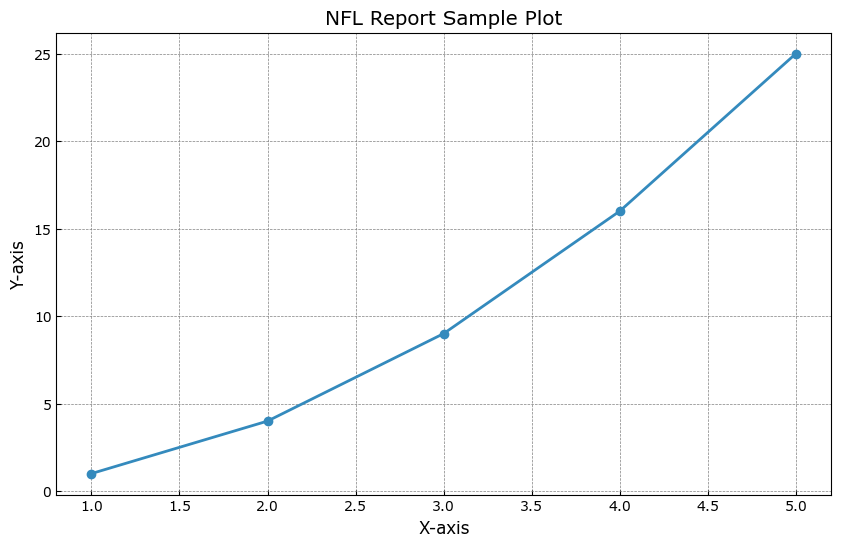

In [21]:
import matplotlib.pyplot as plt
import matplotlib as mpl


mpl.rc('font', family='Verdana')


plt.rcParams.update({
    'figure.figsize': (10, 6),
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.grid': True,
    'grid.color': 'grey',
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'axes.labelcolor': 'black',
    'axes.labelsize': 'large',
    'axes.titlesize': 'x-large',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'xtick.labelsize': 'medium',
    'ytick.labelsize': 'medium',
    'legend.frameon': True,
    'legend.framealpha': 0.7,
    'legend.facecolor': 'white',
    'legend.edgecolor': 'black'
})

# Sample Plot
x = [1, 2, 3, 4, 5]
y = [1, 4, 9, 16, 25]
plt.plot(x, y, marker='o')
plt.title('NFL Report Sample Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [22]:
plays_df_keep_cols = ['gameId', 'playId','expectedPoints', 'expectedPointsAdded','homeTeamWinProbabilityAdded','quarter', 'down', 'yardsToGo']
eda_df = (
    model_df
    .merge(plays_df[plays_df_keep_cols], on=['playId', 'gameId','yardsToGo'])
    .assign(Down=lambda df: df['down'].astype('category'),
            discrete_yards_from_goal=lambda df: pd.qcut(df['yards_from_td'], q=4),
            yardsToGoCategory=lambda df: pd.cut(df['yardsToGo'],
                                                bins=[-np.inf, 3, 7, 10, np.inf],
                                                labels=['short', 'mid', 'long', 'very long'])
            )
)

In [23]:
plays_df.columns

Index(['gameId', 'playId', 'ballCarrierId', 'ballCarrierDisplayName',
       'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'gameClock',
       'preSnapHomeScore', 'preSnapVisitorScore', 'passResult', 'passLength',
       'penaltyYards', 'prePenaltyPlayResult', 'playResult',
       'playNullifiedByPenalty', 'absoluteYardlineNumber', 'offenseFormation',
       'defendersInTheBox', 'passProbability', 'preSnapHomeTeamWinProbability',
       'preSnapVisitorTeamWinProbability', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPoints', 'expectedPointsAdded',
       'foulName1', 'foulName2', 'foulNFLId1', 'foulNFLId2', 'abs_score_diff',
       'playDirection', '_merge', 'yards_from_td', 'ball_carrier_height',
       'ball_carrier_weight'],
      dtype='object')

In [24]:
plays_df['yardsToGo'].describe()

count    3229.000000
mean        9.289254
std         3.966473
min         1.000000
25%         7.000000
50%        10.000000
75%        10.000000
max        30.000000
Name: yardsToGo, dtype: float64

# YAC Plot for report

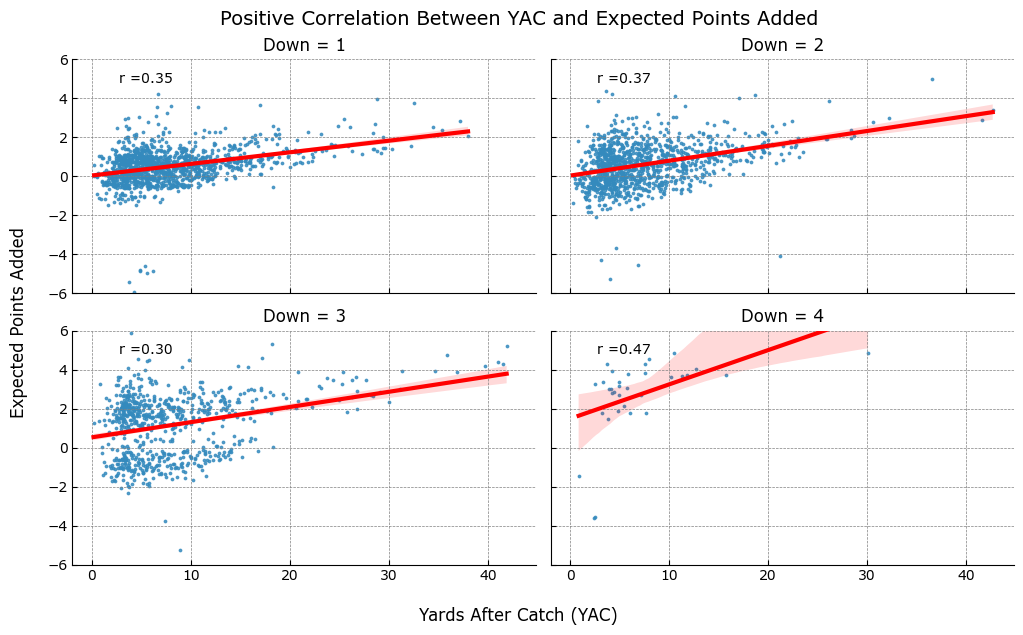

In [30]:
# Assuming eda_df is your DataFrame
# eda_df = pd.DataFrame(...)

# Create a FacetGrid with an adjusted aspect ratio for wider plots
g = sns.FacetGrid(eda_df, col='Down', col_wrap=2, aspect=1.7)

# Custom function to plot regplot and annotate with Pearson r
def regplot_with_r(x, y, **kwargs):
    sns.regplot(x=x, y=y, **kwargs)
    r, _ = stats.pearsonr(x, y)
    plt.annotate(f'r ={r:.2f}', xy=(0.1, 0.9), xycoords='axes fraction', fontsize=10)

# Map the custom function to the grid
g.map(regplot_with_r, 'yac', 'expectedPointsAdded', scatter_kws={'s': 3}, line_kws={'color': 'red'})

# Set the y-axis limits and ticks to even numbers
g.set(ylim=(-6, 6), yticks=np.arange(-6, 7, 2))

# Remove the individual axis labels set in the function
for ax in g.axes.flat:
    ax.set_xlabel('')
    ax.set_ylabel('')

# Set a single x and y axis label for the entire grid
g.fig.text(0.5, 0.01, 'Yards After Catch (YAC)', ha='center', va='center', fontsize=12)
g.fig.text(0.01, 0.5, 'Expected Points Added', ha='center', va='center', rotation='vertical', fontsize=12)

# Set an overall title for the FacetGrid closer to the plots
g.fig.suptitle('Positive Correlation Between YAC and Expected Points Added', fontsize=14, y=1.02)
g.savefig("report_images/yac_vs_epa_plot.png")
# Show the plot
plt.show()

In [26]:
# Group by 'ballCarrierDisplayName' and filter groups with at least 10 entries
filtered_groups = eda_df.groupby('ballCarrierDisplayName').filter(lambda x: len(x) >= 6)

# Calculate the mean 'yac' for each player in the filtered groups
mean_yac = (
    filtered_groups
    .groupby('ballCarrierDisplayName', as_index=False)
    .agg({'yac': 'mean'})
    .sort_values('yac', ascending=False)
)

# Display the results
print(mean_yac)

    ballCarrierDisplayName        yac
165         Travis Etienne  16.120000
59       Dontrell Hilliard  14.846667
28         Colby Parkinson  14.508333
54           Derrick Henry  13.993638
36          Dallas Goedert  12.828500
..                     ...        ...
172          Tyler Lockett   4.108635
161         T.J. Hockenson   4.043637
4              Alec Pierce   3.675455
125         Michael Thomas   3.668999
167        Trent Sherfield   3.167142

[180 rows x 2 columns]


<Axes: xlabel='yac', ylabel='Count'>

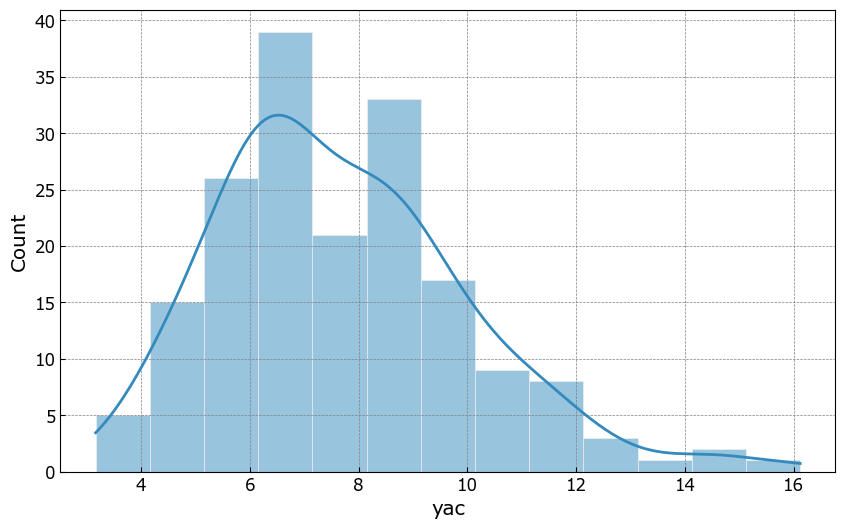

In [119]:
sns.histplot(mean_yac['yac'], kde= True)